# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
# import all modules required

import idx2numpy
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# read the idx files

train_images_raw = idx2numpy.convert_from_file('./MNIST/train-images.idx3-ubyte')
train_labels_raw = idx2numpy.convert_from_file('./MNIST/train-labels.idx1-ubyte')
test_images_raw = idx2numpy.convert_from_file('./MNIST/t10k-images.idx3-ubyte')
test_labels_raw = idx2numpy.convert_from_file('./MNIST/t10k-labels.idx1-ubyte')
print "Raw training set size- ", train_images_raw.shape, train_labels_raw.shape
print "Raw testing set size- ", test_images_raw.shape, test_labels_raw.shape

Raw training set size-  (60000, 28, 28) (60000,)
Raw testing set size-  (10000, 28, 28) (10000,)


In [3]:
# function to shuffle data

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [4]:
# shuffle the data

train_images_raw, train_labels_raw = randomize(train_images_raw, train_labels_raw)
test_images_raw, test_labels_raw = randomize(test_images_raw, test_labels_raw)

In [5]:
# normalize images for mean ~ 0 and standard deviation ~ 0.5

pixel_depth = 255.0                   # number of levels per pixel

normalized_train_images = (train_images_raw.astype(float) - pixel_depth / 2) / pixel_depth
normalized_test_images = (test_images_raw.astype(float) - pixel_depth / 2) / pixel_depth

In [6]:
num_concat_images = 5                 # number of images (containing digits or 'blank') to be concatenated
image_size = 28
blank_image = np.ones((image_size,image_size))*(-1)   # image with a 'blank' character
blank_label = 10                      # label for the 'blank' character

In [7]:
# function to concatenate images and labels to create sequences of digits
# between 1 and 5 digits are concatenated and the 'blank' character is incorporated

def concatenate(dataset, labels):
    concat_images = []
    concat_labels = []
    pos = 0
    while pos < dataset.shape[0]:
        # randomly select between 1 and 5 number of digits to be concatenated
        num_images = random.randint(1,num_concat_images)
        if pos + num_images <= dataset.shape[0]:
            temp_images_list = []
            temp_labels_list = []
            # add the selected number or digits to a temporary list
            for i in range(0,num_images):
                temp_images_list.append(dataset[pos+i])
                temp_labels_list.append(labels[pos+i])
            pos += num_images
            # fill in the rest of the list with 'blank' characters to reach size of 5
            for i in range(len(temp_images_list),num_concat_images):
                temp_images_list.append(blank_image)
                temp_labels_list.append(blank_label)
                
            # convert the lists into numpy arrays and randomize them
            temp_images_list = np.array(temp_images_list)
            temp_labels_list = np.array(temp_labels_list)
            temp_images_list, temp_labels_list = randomize(temp_images_list, temp_labels_list)
            
            # concatenate the images and their labels
            concatenated_image = temp_images_list[0]
            concatenated_label = []
            concatenated_label.append(temp_labels_list[0])
            for i in range(1,num_concat_images):
                concatenated_image = np.hstack([concatenated_image,temp_images_list[i]])
                concatenated_label.append(temp_labels_list[i])
            
            # append the concatenated images and labels to the final list
            concat_images.append(concatenated_image)
            concat_labels.append(tuple(concatenated_label))
    
    # convert final lists into numpy arrays and return
    concat_images = np.array(concat_images)
    concat_labels = np.array(concat_labels)
    return concat_images, concat_labels

In [8]:
# concatenate training and testing data

train_images, train_labels = concatenate(normalized_train_images, train_labels_raw)
test_images, test_labels = concatenate(normalized_test_images, test_labels_raw)
print "Concatenated training set size- ", train_images.shape, train_labels.shape
print "Concatenated testing set size- ", test_images.shape, test_labels.shape

Concatenated training set size-  (20121, 28, 140) (20121, 5)
Concatenated testing set size-  (3362, 28, 140) (3362, 5)


After concatenation, sample training images- 


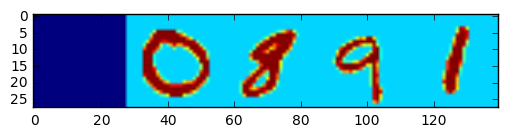

Label : [10  0  8  9  1]


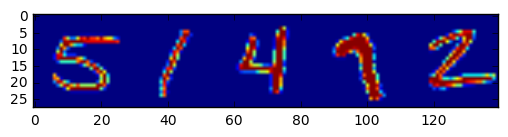

Label : [5 1 4 7 2]
After concatenation, sample testing images- 


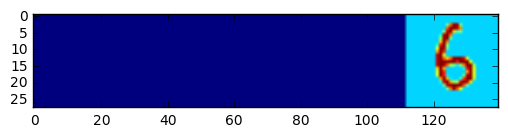

Label : [10 10 10 10  6]


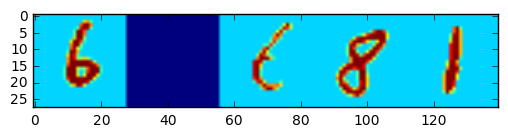

Label : [ 6 10  6  8  1]


In [9]:
# display concatenated training and testing sample images

print "After concatenation, sample training images- "
for i in range(0,2):
    rand_num = random.randint(0,train_images.shape[0])
    plt.imshow(train_images[rand_num])
    plt.show()
    print ('Label : {}'.format(train_labels[rand_num]))
    
print "After concatenation, sample testing images- "
for i in range(0,2):
    rand_num = random.randint(0,test_images.shape[0])
    plt.imshow(test_images[rand_num])
    plt.show()
    print ('Label : {}'.format(test_labels[rand_num]))

In [10]:
# split the training data into training and validation datasets

validation_train_split_ratio = 0.2

validation_data_size = int(train_images.shape[0]*validation_train_split_ratio)

validation_images = train_images[0:validation_data_size]
validation_labels = train_labels[0:validation_data_size]

train_images = train_images[validation_data_size:]
train_labels = train_labels[validation_data_size:]

print "Training set size- ", train_images.shape, train_labels.shape
print "Validation set size- ", validation_images.shape, validation_labels.shape

Training set size-  (16097, 28, 140) (16097, 5)
Validation set size-  (4024, 28, 140) (4024, 5)


In [11]:
# function for segmenting images

def segment(dataset, labels):
    segmented_datasets = np.ndarray(shape=(num_concat_images,dataset.shape[0],image_size,image_size))
    segmented_labels = np.ndarray(shape=(num_concat_images,labels.shape[0]))
    for i in range(0,num_concat_images):
        segmented_datasets[i] = dataset[:,:,(i*image_size):((i+1)*image_size)]
        segmented_labels[i] = labels[:,i]

    return segmented_datasets, segmented_labels

# segment training, validation and testing datasets

training_datasets, training_labelsets = segment(train_images,train_labels)
validation_datasets, validation_labelsets = segment(validation_images,validation_labels)
testing_datasets, testing_labelsets = segment(test_images,test_labels)

print "Segmented training dataset size- ", training_datasets.shape, training_labelsets.shape
print "Segmented validation dataset size- ", validation_datasets.shape, validation_labelsets.shape
print "Segmented testing dataset size- ", testing_datasets.shape, testing_labelsets.shape

Segmented training dataset size-  (5, 16097, 28, 28) (5, 16097)
Segmented validation dataset size-  (5, 4024, 28, 28) (5, 4024)
Segmented testing dataset size-  (5, 3362, 28, 28) (5, 3362)


In [12]:
# functions for formatting data to suit TensorFlow Convolutional Neural Nets

num_labels = 11
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

def reformat_segmented_sets(segmented_datasets, segmented_labelsets):
    reformatted_segmented_datasets = np.ndarray(shape=(num_concat_images,segmented_datasets.shape[1],image_size,image_size,num_channels))
    reformatted_segmented_labelsets = np.ndarray(shape=(num_concat_images,segmented_labelsets.shape[1],num_labels))
    for i in range(0,num_concat_images):
        reformatted_segmented_datasets[i], reformatted_segmented_labelsets[i] = reformat(segmented_datasets[i],segmented_labelsets[i])

    return reformatted_segmented_datasets, reformatted_segmented_labelsets

# reformat the data

training_datasets, training_labelsets = reformat_segmented_sets(training_datasets, training_labelsets)
validation_datasets, validation_labelsets = reformat_segmented_sets(validation_datasets, validation_labelsets)
testing_datasets, testing_labelsets = reformat_segmented_sets(testing_datasets, testing_labelsets)

print "Reformatted segmented training dataset size- ", training_datasets.shape, training_labelsets.shape
print "Reformatted segmented validation dataset size- ", validation_datasets.shape, validation_labelsets.shape
print "Reformatted segmented testing dataset size- ", testing_datasets.shape, testing_labelsets.shape

Reformatted segmented training dataset size-  (5, 16097, 28, 28, 1) (5, 16097, 11)
Reformatted segmented validation dataset size-  (5, 4024, 28, 28, 1) (5, 4024, 11)
Reformatted segmented testing dataset size-  (5, 3362, 28, 28, 1) (5, 3362, 11)


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.